<a href="https://colab.research.google.com/github/calebmckay1/DS-Unit-2-Kaggle-Challenge/blob/master/module4-classification-metrics/LS_DS_224_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](http://archive.is/DelgE), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import pandas as pd
import numpy as np

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [0]:
from sklearn.model_selection import train_test_split
target = 'status_group'
train, val = train_test_split(train, test_size=len(test),
                              stratify=train[target], random_state=42)

In [23]:
train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
45793,41413,0.0,2011-03-30,NaN,0,NaN,33.075583,-9.385449,Kwa Mwazembe,0,Lake Nyasa,Itaba,Mbeya,12,5,Ileje,Chitete,0,True,GeoData Consultants Ltd,VWC,NaN,False,0,nira/tanira,nira/tanira,handpump,vwc,user-group,unknown,unknown,unknown,unknown,dry,dry,shallow well,shallow well,groundwater,hand pump,hand pump,non functional
26326,48397,500.0,2011-02-28,Dhv,285,DWE,36.228574,-8.207742,Kwamwampwaga,0,Rufiji,Igima,Morogoro,5,3,Kilombero,Mbingu,1000,True,GeoData Consultants Ltd,NaN,NaN,True,1984,swn 80,swn 80,handpump,vwc,user-group,pay monthly,monthly,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,non functional
53251,6910,0.0,2013-01-27,Finw,218,FinW,39.673635,-10.835281,Pachani,0,Ruvuma / Southern Coast,Mnyekehe,Mtwara,9,4,Tandahimba,Naputa,260,True,GeoData Consultants Ltd,Water Board,Borehole,True,1982,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
26791,12526,500.0,2011-02-27,Adb,1704,DWE,34.915589,-9.016965,Kwa Mwangayange Mfumbilwa,0,Rufiji,Ndanula,Iringa,11,4,Njombe,Igongolo,40,True,GeoData Consultants Ltd,VWC,Ibiki gravity water scheme,False,2008,gravity,gravity,gravity,vwc,user-group,pay monthly,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
2162,17511,200.0,2013-01-18,Dwe,1232,DWE,30.332034,-4.308921,Kwa Bungwa,0,Lake Tanganyika,Nyakerera,Kigoma,16,2,Kasulu,Kitagata,500,True,GeoData Consultants Ltd,Water authority,Nyachenda,True,2003,gravity,gravity,gravity,vwc,user-group,pay monthly,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional


In [0]:
%matplotlib inline
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestClassifier

def wrangle(x):
    x2 = x.copy()
    x2['date_recorded'] = pd.to_datetime(x2['date_recorded'], infer_datetime_format=True)
    x2['year_recorded'] = x2['date_recorded'].dt.year
    x2['month_recorded'] = x2['date_recorded'].dt.month
    x2['day_recorded'] = x2['date_recorded'].dt.day

    taking_out_the_trash = ['longitude','latitude','date_recorded',
               'extraction_type_group','extraction_type_class',
               'region_code','waterpoint_type_group','source_type',
              'payment_type','quality_group','quantity_group']
    x2 = x2.drop(columns=taking_out_the_trash)
    x2['years'] = x2['year_recorded'] - x2['construction_year']    
    
    unusable_variance = ['recorded_by', 'id']
    x2 = x2.drop(columns=unusable_variance)
        
    cols_with_zeros = ['construction_year', 'gps_height', 'population']
    for col in cols_with_zeros:
        x2[col] = x2[col].replace(0, np.nan)
        
    return x2

In [0]:
x_train = train.drop(columns=target)
y_train = train[target]
x_val = val.drop(columns=target)
y_val = val[target]
x_test = test

In [0]:
pipeline = make_pipeline(
    FunctionTransformer(wrangle, validate=False), 
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

In [75]:
pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

Validation Accuracy 0.8028276918790918


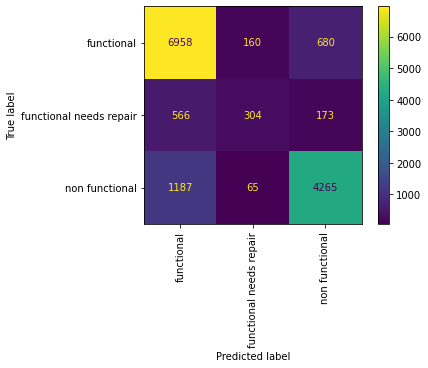

In [61]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(pipeline, X_val, y_val, values_format='.0f', xticks_rotation='vertical');

In [66]:
correct_predictions = 6958 + 304 + 4265
correct_predictions

11527

In [67]:
total_predictions = 6958 + 160 + 680 + 566 + 304 + 173 + 1187 + 65 + 4265
total_predictions

14358

In [68]:
correct_predictions / total_predictions

0.8028276918790918

In [69]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

                         precision    recall  f1-score   support

             functional       0.80      0.89      0.84      7798
functional needs repair       0.57      0.29      0.39      1043
         non functional       0.83      0.77      0.80      5517

               accuracy                           0.80     14358
              macro avg       0.74      0.65      0.68     14358
           weighted avg       0.80      0.80      0.79     14358



In [0]:
x_test['status_group'] = pipeline.predict(x_test)
test_final = x_test[['id', 'status_group']]

In [77]:
test_final.head()

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


In [0]:
test_final.to_csv('prediction.csv',index=False)
from google.colab import files
files.download('prediction.csv')